# Car Brands Predictor

**Task:**

* Apply concepts about CNN and transfer learning to develop a model that can predict what is the brand of a car from an image. 

# Importation 

In [1]:
import numpy as np 
import pandas as pd 
import os
from PIL import Image
from tensorflow.keras.applications.efficientnet import preprocess_input
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import cv2
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from keras.optimizers import Nadam
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

### GPU config

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Image importation

In [3]:
for dirname, _, filenames in os.walk('car_brands'):
    for filename in filenames:
        os.path.join(dirname, filename)

# Image preprocessing

* Run in the directory where are the images.
* Resize the images and maintaining the original relation size.
    * Smaller images are not enlarged to not lose quality.   
    * Normalize values of every pixel. 
* Shuffle the data
* X as images.
* y as brands. 

In [4]:
base_dir = "Local-Dir"
data = []
IMAGE_SIZE = (224, 224)

# Move on every folder of base_dir
for marca in os.listdir(base_dir):
    marca_dir = os.path.join(base_dir, marca)

    # Check if brand is a directory
    if os.path.isdir(marca_dir):
        
        # Move on every image in the folder
        for img_file in os.listdir(marca_dir):
            img_path = os.path.join(marca_dir, img_file)
            
            # Read and open the image
            img = Image.open(img_path)
            # Converto to grayscale
            #img = img.convert("L").convert(img.mode)
            # Resize the image, maintaining the original aspect ratio
            img.thumbnail(IMAGE_SIZE)
            
            # Generate a new image with necessary size and paste the image in the center
            new_img = Image.new("RGB", IMAGE_SIZE) # RGB generate 3 channels. 
            new_img.paste(img, ((IMAGE_SIZE[0] - img.size[0]) // 2, (IMAGE_SIZE[1] - img.size[1]) // 2))
            
            # Change image to numpy array
            img_array = np.array(new_img)
            
            # Normalize pixels [0, 1]
            img_array = img_array / 255.0
            
            # Add images and brand name to data
            data.append((img_array, marca))

# Shuffle data
np.random.shuffle(data)

# Organize in X and y
X = np.array([item[0] for item in data])  # Images
y = np.array([item[1] for item in data])  # Brands

# Shape
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

c:\Users\santi\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Shape of X: (5045, 224, 224, 3)
Shape of y: (5045,)


# Image Dataset

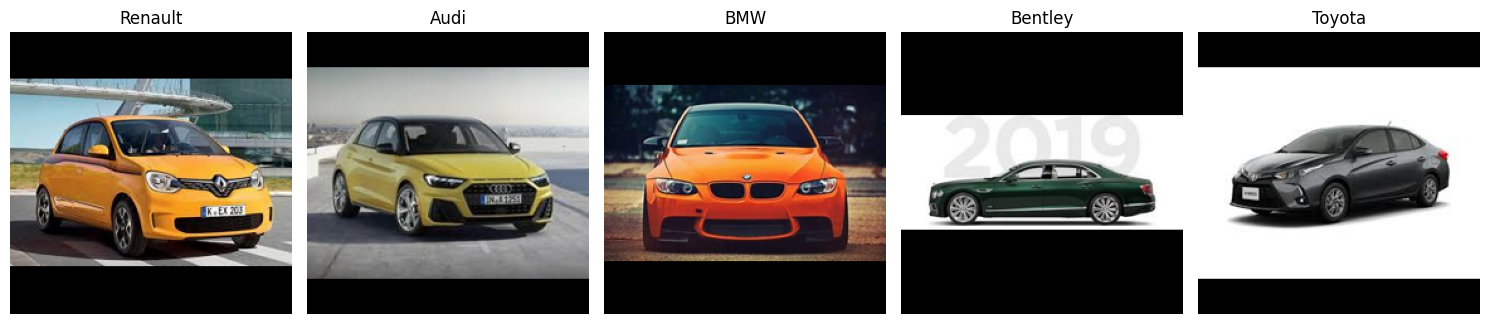

In [5]:
# Obtain 5 images to show  previously
random_indices = random.sample(range(len(X)), 5)

plt.figure(figsize=(15, 5))
for i, idx in enumerate(random_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[idx], cmap='gray') # Images
    plt.title(y[idx]) # Brands
    plt.axis('off')
# Fix the space between images
plt.tight_layout()

# Show the images
plt.show()

# EDA Brand Distribution



Generate a DataFrame to analize how many images there are of every brand. 

In [6]:
df_y = pd.DataFrame(y,columns=['Brand'])

In [7]:
df_y

,Brand
0,Ford
1,GMC
2,Mini
3,Ford
4,GMC
...,...
5040,Ram Trucks
5041,Ram Trucks
5042,Mercedes-Benz
5043,BMW


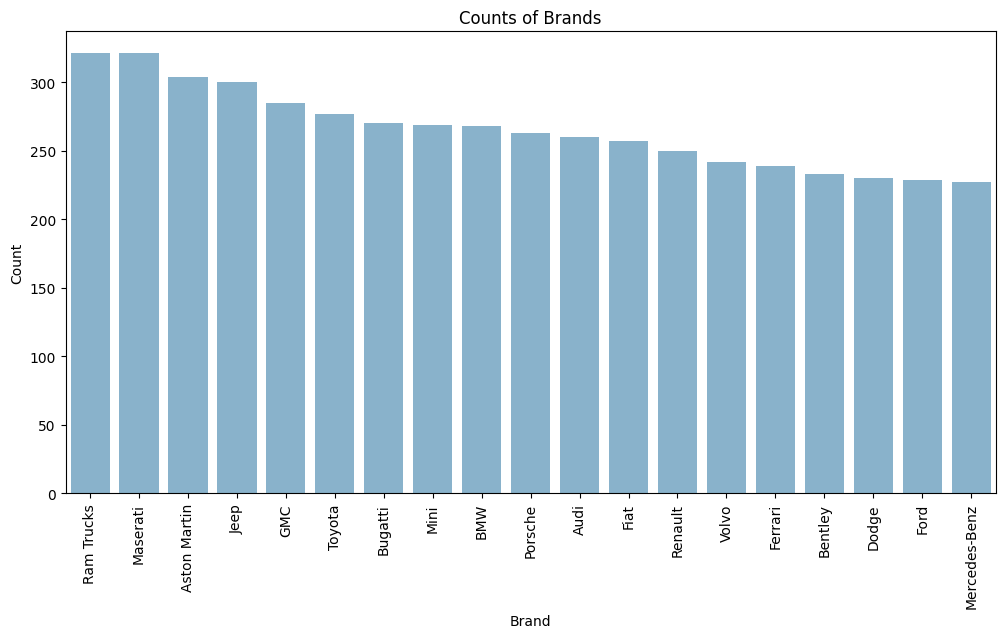

In [8]:
brand_counts = df_y['Brand'].value_counts()

plt.figure(figsize=(12, 6))  
sns.barplot(x=brand_counts.index, y=brand_counts.values, color='#7eb5d6')

plt.xlabel('Brand')
plt.ylabel('Count')
plt.title('Counts of Brands')
plt.xticks(rotation=90)
plt.show()

# Brand to categorical

Convert 'y' from 'str' to categorical.

In [9]:
label_encoder = LabelEncoder()

# Convert text labels to numeric values
y_encoded = label_encoder.fit_transform(df_y['Brand'])

# Convert numeric values to one-hot vectors using to_categorical
y_OHE = []
y_OHE.append(to_categorical(label_encoder.transform(y)))
print(f"Shape of y_OHE: {y_OHE[0].shape}")

Shape of y_OHE: (5045, 19)


# Train-Test-Val division

In [10]:
# Aplica train_test_split para dividir los lotes en conjuntos de entrenamiento, validación y prueba
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y_OHE[0], test_size=0.05, random_state=42)
# Divide los datos de entrenamiento en datos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.05, random_state=42)

# Verifica las formas de los conjuntos de entrenamiento, validación y prueba
print("Forma de X_train: {}".format(X_train.shape))
print("Forma de X_val: {}".format(X_val.shape))
print("Forma de X_test: {}".format(X_test.shape))
print("Forma de y_train: {}".format(y_train.shape))
print("Forma de y_val: {}".format(y_val.shape))
print("Forma de y_test: {}".format(y_test.shape))

Forma de X_train: (4552, 224, 224, 3)
Forma de X_val: (240, 224, 224, 3)
Forma de X_test: (253, 224, 224, 3)
Forma de y_train: (4552, 19)
Forma de y_val: (240, 19)
Forma de y_test: (253, 19)


# Model Desing

### base_model: EfficientNetV2S

In [11]:
# Import base_model:
base_model = keras.applications.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3),
    pooling="avg",
    include_preprocessing=False,
)
base_model.trainable = False

Allow training on the last layers of the model.

In [12]:
#for layer in base_model.layers[:-3]:
#    layer.trainable = True

### Model Sequential

In [13]:
model = keras.Sequential([
    base_model,  
    layers.Dense(500, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(19, activation='softmax'),
])

### Model Fitting

In [14]:
optimizer = Nadam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)
history = []
hist = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=16,
    )
history.append(hist)

Epoch 1/20
285/285 [==============================] - 33s 60ms/step - loss: 2.2828 - accuracy: 0.2476 - val_loss: 1.9929 - val_accuracy: 0.3875
Epoch 2/20
285/285 [==============================] - 14s 51ms/step - loss: 1.8168 - accuracy: 0.3998 - val_loss: 1.7378 - val_accuracy: 0.4292
Epoch 3/20
285/285 [==============================] - 15s 52ms/step - loss: 1.5994 - accuracy: 0.4785 - val_loss: 1.4317 - val_accuracy: 0.5583
Epoch 4/20
285/285 [==============================] - 14s 51ms/step - loss: 1.4325 - accuracy: 0.5330 - val_loss: 1.5595 - val_accuracy: 0.4917
Epoch 5/20
285/285 [==============================] - 15s 51ms/step - loss: 1.2830 - accuracy: 0.5877 - val_loss: 1.4315 - val_accuracy: 0.5792
Epoch 6/20
285/285 [==============================] - 15s 52ms/step - loss: 1.1595 - accuracy: 0.6281 - val_loss: 1.4089 - val_accuracy: 0.5833
Epoch 7/20
285/285 [==============================] - 15s 51ms/step - loss: 1.0700 - accuracy: 0.6560 - val_loss: 1.3585 - val_accuracy:

# Test Evaluation

### Preprocessing y_pred

In [15]:
# Prediction 
y_pred = model.predict(X_test)

# Example
print("Predicciones del primer ejemplo:",np.argmax(y_pred[0]) )
print(y_pred[0])

8/8 [==============================] - 3s 81ms/step
Predicciones del primer ejemplo: 11
[4.0487896e-05 1.9798596e-05 1.7004508e-03 1.5259787e-04 2.1999580e-07
 5.8832875e-06 1.3503110e-06 6.3800691e-08 2.8694323e-08 7.1258922e-11
 1.8945527e-06 9.9722219e-01 7.8047940e-04 1.3089522e-08 3.3140379e-05
 1.3263308e-08 5.4670754e-06 7.4865011e-06 2.8522894e-05]


Binarize the result

In [16]:
# Find the max value in the prediction.
max_indices = np.argmax(y_pred, axis=1)
# Create and array of zeros.
y_pred_bin = np.zeros_like(y_pred)
# Stablish that in the positions where is the max value, be =1.
y_pred_bin[np.arange(len(y_pred)), max_indices] = 1

In [17]:
print("Matriz binarizada del primer ejemplo:", np.argmax(y_pred_bin[0]))
print(y_pred_bin[0])

Matriz binarizada del primer ejemplo: 11
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


## Report

* Evaluation with accuracy_score.

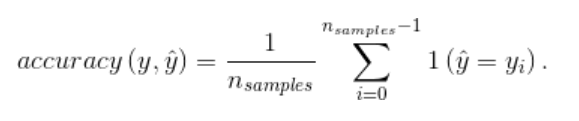

* Classification Report.


In [18]:
accuracy = accuracy_score(y_test, y_pred_bin)
report = classification_report(y_test, y_pred_bin)
print(accuracy,'\n',report)

0.7075098814229249 
               precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       0.47      0.67      0.55        12
           2       0.77      0.71      0.74        14
           3       1.00      0.78      0.88         9
           4       0.92      0.92      0.92        12
           5       0.67      0.57      0.62         7
           6       1.00      0.88      0.93        16
           7       0.57      0.62      0.59        13
           8       0.71      0.42      0.53        12
           9       0.91      0.77      0.83        13
          10       0.79      0.79      0.79        14
          11       0.62      0.62      0.62        13
          12       0.62      0.73      0.67        11
          13       0.86      0.71      0.77        17
          14       0.59      0.91      0.71        11
          15       0.55      0.84      0.67        19
          16       0.54      0.50      0.52        14
      

In [29]:
label_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}
brands_label = pd.DataFrame(label_mapping.items(), columns=['Label','Brand'])
print("Mapping of original labels to numerical values:")
print(brands_label)

Mapping of original labels to numerical values:
    Label          Brand
0       0   Aston Martin
1       1           Audi
2       2            BMW
3       3        Bentley
4       4        Bugatti
5       5          Dodge
6       6        Ferrari
7       7           Fiat
8       8           Ford
9       9            GMC
10     10           Jeep
11     11       Maserati
12     12  Mercedes-Benz
13     13           Mini
14     14        Porsche
15     15     Ram Trucks
16     16        Renault
17     17         Toyota
18     18          Volvo


## Confusion Matrix

In [20]:
y_test_original = np.argmax(y_test, axis=1)
y_pred_original = np.argmax(y_pred_bin, axis=1)

y_test_original = label_encoder.inverse_transform(y_test_original)
y_pred_original = label_encoder.inverse_transform(y_pred_original)

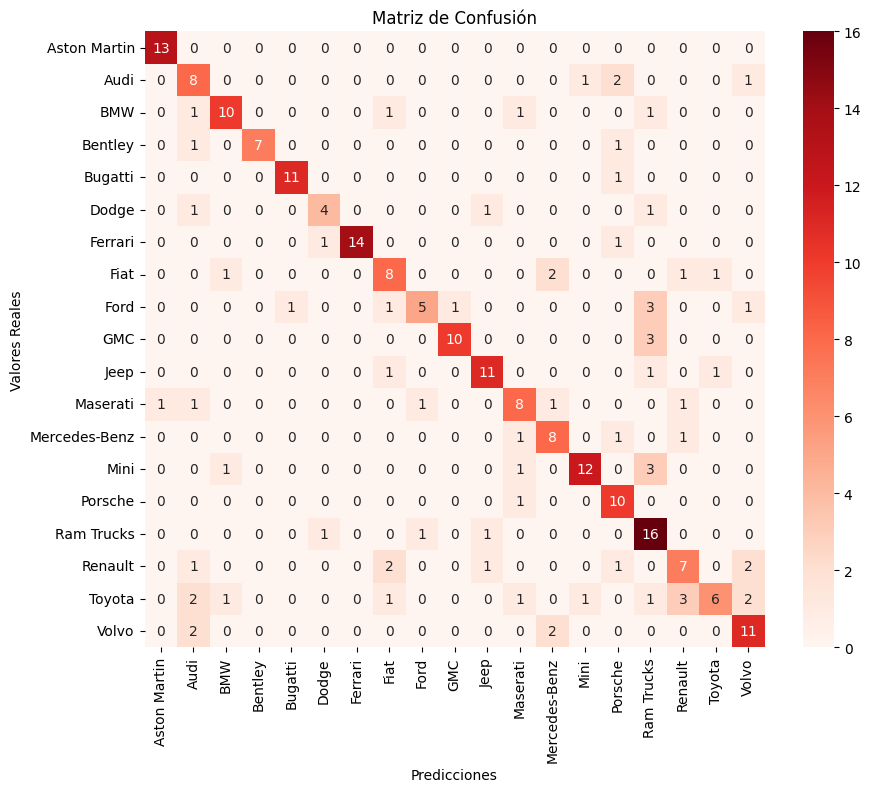

In [21]:
# Confusion Matrix
cm = confusion_matrix(y_test_original, y_pred_original)

# Plot cm
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Reds', fmt='d', xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión')
plt.show()

## Result Images

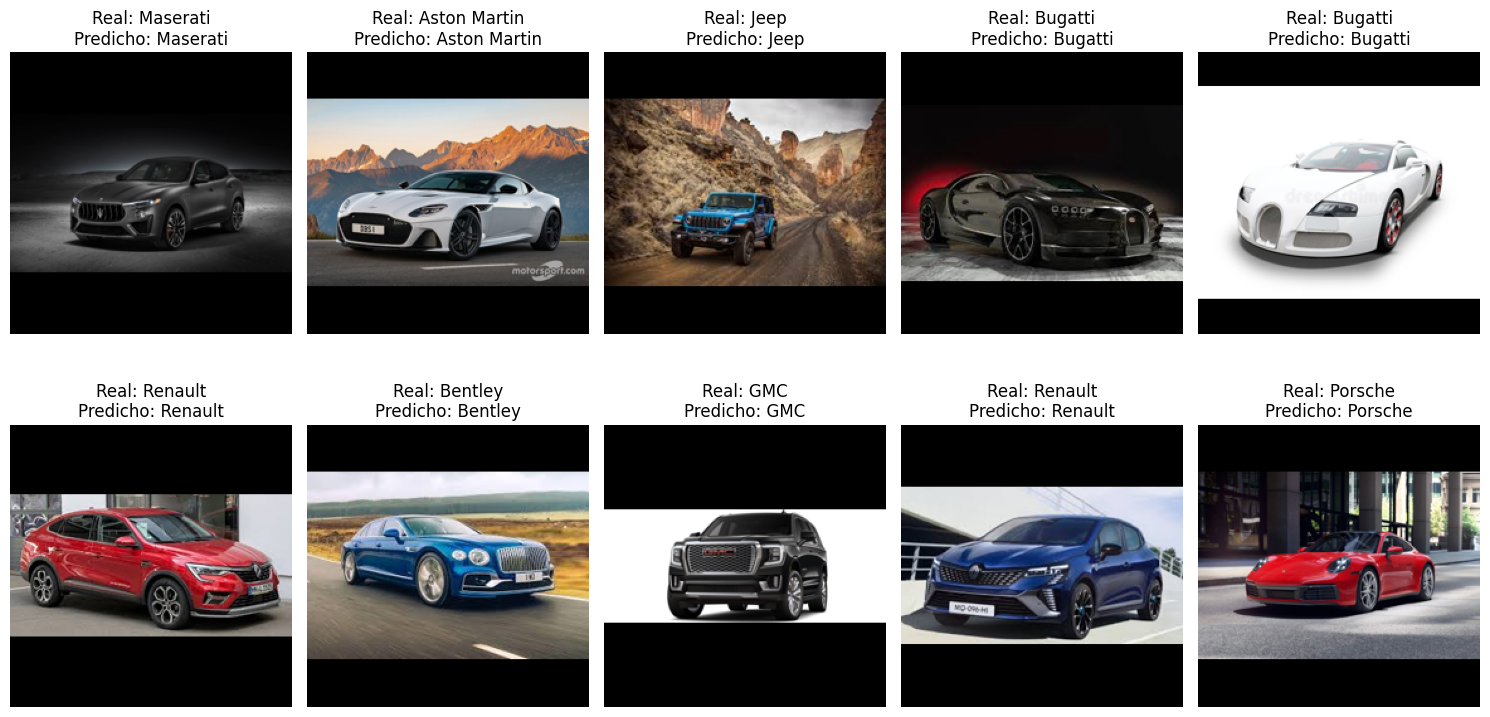

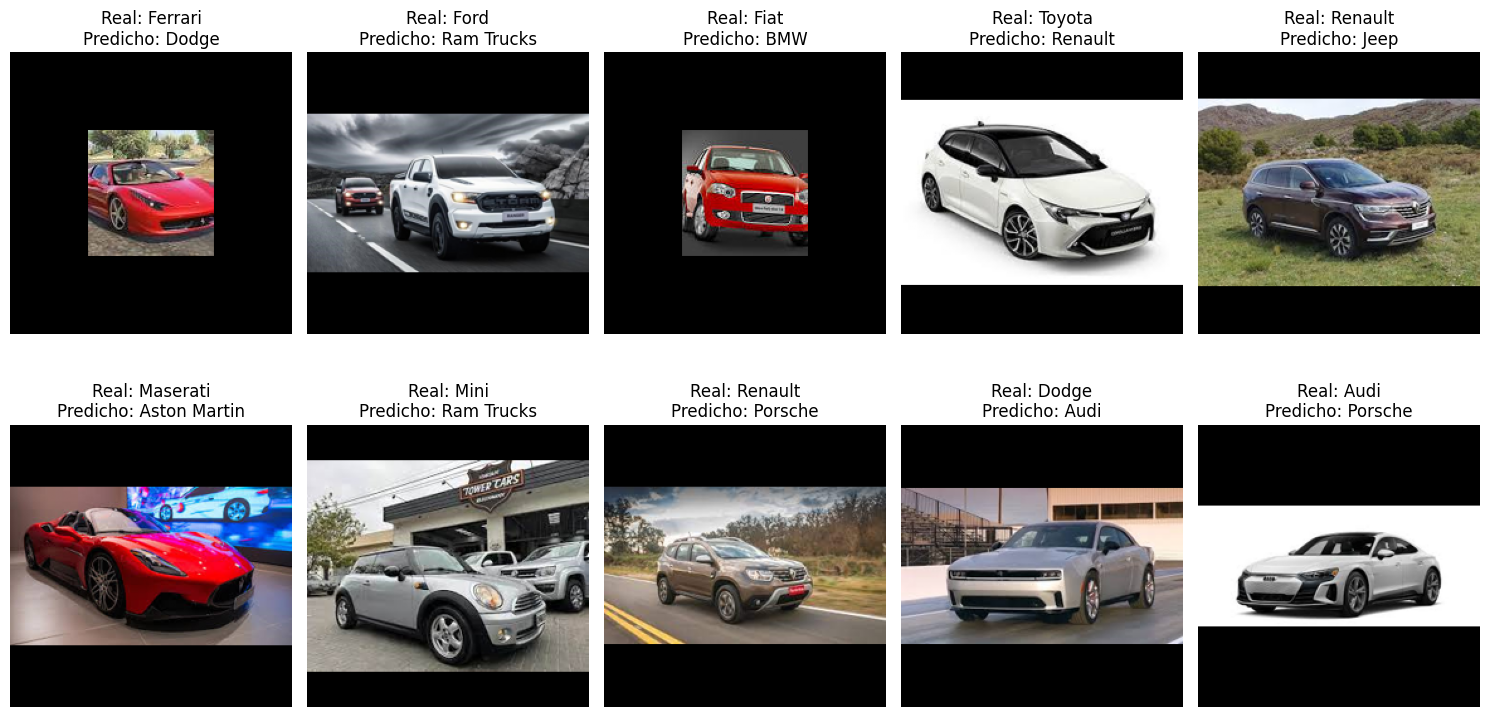

In [32]:
# Encuentra índices de ejemplos bien etiquetados y mal etiquetados
indices_correctos = np.where(y_pred_original == y_test_original)[0]
indices_incorrectos = np.where(y_pred_original != y_test_original)[0]

# Selecciona 5 ejemplos bien etiquetados y 5 mal etiquetados para mostrar en el gráfico
indices_a_mostrar_bien = np.concatenate([indices_correctos[:10]])
indices_a_mostrar_mal = np.concatenate([indices_incorrectos[:10]])

# Configura el gráfico
plt.figure(figsize=(15, 8))
for i, idx in enumerate(indices_a_mostrar_bien):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[idx])
    plt.title(f'Real: {y_test_original[idx]}\nPredicho: {y_pred_original[idx]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 8))
for i, idx in enumerate(indices_a_mostrar_mal):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[idx])
    plt.title(f'Real: {y_test_original[idx]}\nPredicho: {y_pred_original[idx]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Conclusion

Obtained result **0.71 % of accuracy**. 

The conclusion that I can generate is that is a very good result, with a CNN was posible to acert the 70% of the cases but seeing the cases where the model failed, is possible to see some things:

* During the process I understood that the **rear images of the cars do not work**. Nor crop images either. The model needs images of the same type and complete ones.
* Brands with different kind of cars (sport, pick up, hatchback) doesn't be completely recognized by the model. Cases like Ford, GMC, RAM, Renault are the brand with lower accuracy. It is absolutely logic and this is a point of improvement, separate different models, without care the brand. For example, F-100 from Ford or Hilux from Toyota.
* My idea with this project was to develop a model capable of work as the human eye, identifying the particular lines and designs of each brand, but I believe that with a large data set it would even be better to separate into each particular model without consider the brand. **Because CNNs are not good at generalizing, they don't make the relations that we can do**. This is the problem with trucks and cars of the same brand.
* The bases keep being the same, **with good data any model works well**.